# Problem 3: Least squares and regression (3pts)
### <div align="right"> &copy; Ostap Dyhdalovych and Volodymyr Kuchynskyi, 2022 </div>

## Completed by:   
*   First team member
*   Second team member



#### The aim of this assignment is to understand how the idea of the least square solution for system of linear equations can be used to fit and model data with non-linear dependence. The task is to suggest a good time series model for real data of temperature over a long period of time

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


## 1. Least squares and simple linear regression (0.3 pts)

#### Least squares quick refresher
Consider an ***inconsistent*** system of linear equations $$ A\mathbf{x} = \mathbf{y}$$
Inconsistency means that no solution $\mathbf{x}$ exists, i.e. $\mathbf{y} \notin \mathbf{Col}{(A)}$. However, at least one ***least squares solution*** of such system always exists, and it is ***the best approximate solution***. The least squares solution $\mathbf{\hat{x}}$ is the solution to the ***normal equation***
$$A^{\top}A\mathbf{\hat{x}} = A^{\top}\mathbf{y}$$
if the columns of $A$ are linearly independent, then $A^\top A$ is invertible, and the solution is
$$ \mathbf{\hat{x}} = (A^{\top}A)^{-1} A^{\top}\mathbf{y}$$


### **1.1 (0.3 pts)**

We start with the simplest case of linear (affine) model, in which both the  predictor $x$ and the responce $y$ are scalar, and we are looking for the linear dependence
$$ f(x) = a x + b $$
Fill in the missing parts in the code below

> **_NOTE:_** you have to implement the least squares solution by solving the normal equation using basic numpy operations and functions. The use of preexisting solvers, such as `linalg.lstsq` from numpy or from any other library is forbidden.

In [107]:
def solve_least_squares(x: np.ndarray, y:np.ndarray) -> np.ndarray:
    """
    Args:
        x: 1D array of inputs (predictors)
        y: 1D array of outcomes (responses)
    Returns:
        array(slope, intercept): coeff of the linear function
    """
    assert x.ndim == 1
    assert y.ndim == 1
    assert x.shape[0] == y.shape[0]

    slope = 0
    intercept = 0
    # ========= YOUR CODE STARTS HERE ========= #
    dim = x.shape[0]
    
    # reshape x into a 2-dim matrix A with an additional column of ones which will include the intercept
    A = np.concatenate((x.reshape(-1,1), np.full((dim, 1), 1)), axis=1)
    
    # define terms of the equation x = (AT A)^-1 AT b
    b = y
    AT = A.transpose()
    ATA_inv = np.linalg.inv(np.matmul(AT, A))
    ATA_inv_AT = np.matmul(ATA_inv, AT)
    
    # multiply all terms and get a solution
    x = np.matmul(ATA_inv_AT, b)
    slope, intercept = x[0], x[1]

    # ========== YOUR CODE ENDS HERE ========== #
    return np.array([slope, intercept])


In [108]:
def test_solve_least_squares():
    x = np.arange(1, 10)
    y = 3*x + 1

    coeffs = solve_least_squares(x, y)
    # print(coeffs)
    assert np.isclose(coeffs, np.array([3, 1])).all(), 'Incorrect coefficients computed'
    print("TEST 1: SUCCESS")

test_solve_least_squares()

TEST 1: SUCCESS


## 2. Dataset
We will analyze the dataset of average monthly temperatures from 1850 till 2015

In [86]:
temp_data = pd.read_csv("Task3_data.csv")
temp_data["date"] = pd.to_datetime(temp_data["date"])
#temp_data["month"] = temp_data['date'].map(lambda x: (x.year*12 + x.month))
temp_data['avg_temp'].describe()

count    1992.000000
mean        8.571583
std         4.263193
min         0.404000
25%         4.430000
50%         8.850500
75%        12.858500
max        15.482000
Name: avg_temp, dtype: float64

In [87]:
# REMOVED `reset_index()` CALL THAT PRODUCED ValueError!
year_data = temp_data.groupby(temp_data['date'].map(lambda x: x.year)).mean()
year_data

,date,avg_temp
date,,
1850,1850-06-16 12:00:00,7.900667
1851,1851-06-16 12:00:00,8.178583
1852,1852-06-16 08:00:00,8.100167
1853,1853-06-16 12:00:00,8.041833
1854,1854-06-16 12:00:00,8.210500
...,...,...
2011,2011-06-16 12:00:00,9.516000
2012,2012-06-16 08:00:00,9.507333
2013,2013-06-16 12:00:00,9.606500


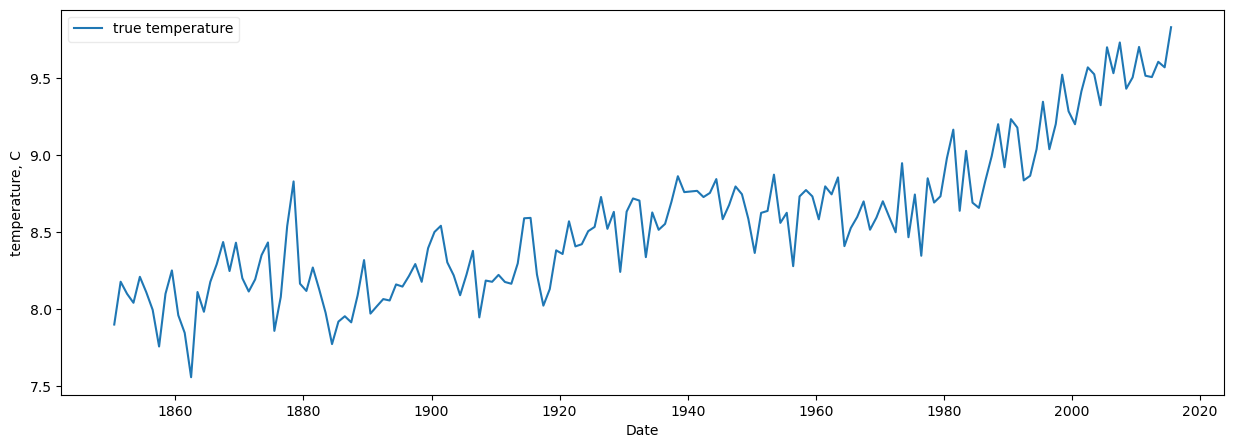

In [89]:
def plot_temps(time, data, prediction=None):
    plt.figure(figsize=(15,5))
    plt.plot(time, data, label="true temperature")

    if not (prediction is None):
        plt.plot(time, prediction, label="predicted temperature")

    plt.xlabel("Date")
    plt.ylabel("temperature, C")
    plt.legend(framealpha=0.4)
    plt.show()

plot_temps(year_data["date"], year_data["avg_temp"])

<!-- Yearly data: Least squares for linear regression -->

## 3. Linear trend for yearly temperature

### **3.1 (0.3 pts)** Find the linear trend for temepratures by solving the corresponding least square problem

In [104]:
def RMSE(predicted, reference):
    return np.sqrt(np.mean((predicted - reference)**2))

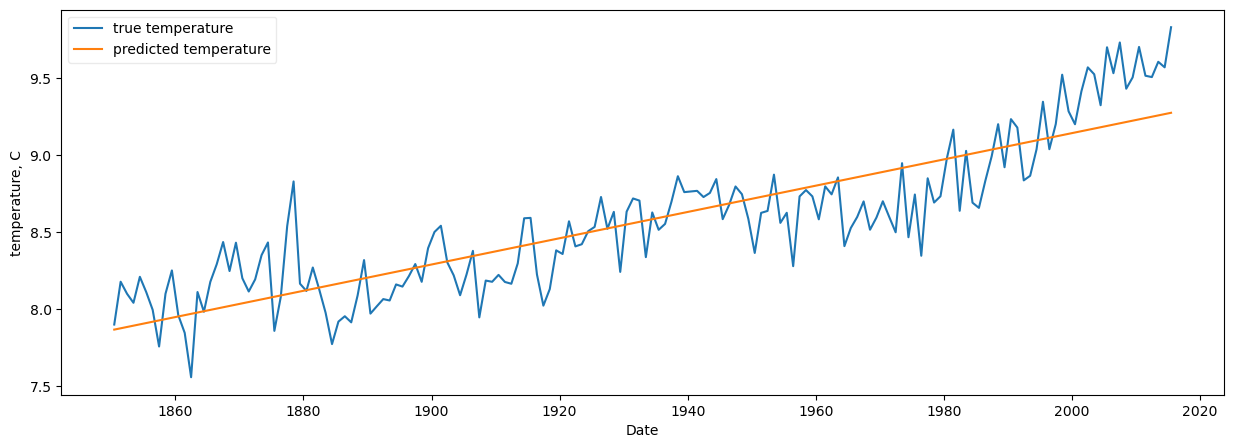

RMSE:  0.23640974195999215


In [106]:
years = np.arange(year_data.shape[0])
temps = year_data['avg_temp'].to_numpy()
slope = None
intercept = None
# ========= YOUR CODE STARTS HERE ========= #
#  Calculate slope and intercept using the function 'solve_least_squares'
slope, intercept = solve_least_squares(years, temps)
# Predict temperature using a linear model
predicted_temps = (years * slope) + intercept
# ========== YOUR CODE ENDS HERE ========== #

plot_temps(year_data["date"], year_data["avg_temp"], predicted_temps)
print("RMSE: ", RMSE(predicted_temps, year_data["avg_temp"]))

## 4. Multilinear regression

In a more general case, we want to represent our target variable as a linear combination of several predictors:
$$ y = a_0 + a_1x_1 + a_2x_2+ \dots + a_nx_n$$


### **4.1 (0.3 pts)** Explain how to apply the least squares method in order to obtain the coefficients $( a_0, a_1, ..., a_n )$ that minimize the sum of squared residuals
$$ \sum_{j=1}^N |y_j - a_0 - a_1x_{1,j} - a_2x_{2,j} - \dots - a_nx_{n,j}|^2 $$

---

In the regression model consisting of several predictros (let us denote them as $(x_1, x_2, ... x_n)$) least squares method of obtaining regression coefficients involves the following steps: 


$\hspace{5mm}$ (1) We first set up matrix $\mathbf{A}$ consisting of rows corresponding to datapoints and columns corresponding to predictor variables. Also, we add a placeholder column of ones which serves as placeholder for slope of each predictor and target variable: 


$$ \mathbf{A} =
\begin{bmatrix}
    1 & x_{1,1} &  x_{2,1} & \dots &  x_{n,1} \\
    1 & x_{1,2} &  x_{2,2} & \dots &  x_{n,2} \\
    \vdots &  \vdots & \vdots & \ddots &  \vdots \\
    1 & x_{1,N} &  x_{2,N} & \dots &  x_{n,N} \\
\end{bmatrix}
$$

$\hspace{5mm}$ (2) The coefficients $\alpha_{0}, \alpha_{1}, ... \alpha_n $ are essentially the coefficients by which we can multiply our matrix $\mathbf A$ containing the observations and get the closest possible vector $\mathbf b$ representing predicted outputs that will be as close as possible to empirical values of a target variable (thus minimizing the sum of squared errors). So, these values are found simply by solving normal equation for $\mathbf x$:

$$ \mathbf{A}^\top \mathbf{A} \mathbf{x} = \mathbf{A}^\top \mathbf{b}$$

$$
    \Longrightarrow \mathbf x = (\mathbf A^{\top} \mathbf A) \mathbf A^{\top}\mathbf{b} = \begin{bmatrix}
    \alpha_0 \\
    \alpha_1 \\
    \vdots \\
    \alpha_{n}
\end{bmatrix} 
$$

thus, $\mathbf x$ is a vector of dimesion $n+1$, that represents the $y$-intercept and slopes for every predictor and target variable. These coefficients will make the predicted outputs $\mathbf{Ax}$ as close as possible to observed output ($\mathbf b$). In geometrical sense, $\mathbf x$ can be thought of as a vector such that, when left-multiplied by $\mathbf A$, we'll get the orthogonal projection of $\mathbf b$ onto the subspace spanned by columns of $\mathbf A$. This projection minimizes the distance between the subspace of $\mathbf A$ and the point represented by $\mathbf b$ and thus, in the context of linear regression, fits line that predicts the output as best as a line can do.

---

### **4.2 (0.4 pts)** Implement multilinear regression in the chunks below

In [5]:
# Multilinear regression via normal equation

def solve_least_squares_general(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Args:
        X: 2D array (x_1, x_2, ..., x_n) of basis variables
        y: 1D array of res
    Returns:
        Coeffs: slope for each variable in X and intercept
    """
    assert X.ndim == 2
    assert X.shape[0] == y.shape[0]
    assert y.ndim == 1
    n = y.shape[0]
    
    A = np.c_[np.ones(X.shape[0]), X]
    coeffs = np.linalg.inv(A.T @ A) @ A.T @ y

    assert coeffs.shape[0] == X.shape[1] + 1  # slope for each x + intercept (CHANGED X.shape[0] TO X.shape[1])

    return coeffs

In [31]:
# predict the values of responce variable in multiplinear regression

def predict_general(X: np.ndarray, coeffs:np.ndarray) -> np.ndarray:
    """
    # TODO:rewrite
    Args:
        X: 2D array (x_1, x_2, ..., x_n) of basis variables
        Coeffs: slope for each variable in X and intercept
    Returns:
        y: predicted values
    """
    assert X.ndim == 2
    assert coeffs.ndim == 1
    assert coeffs.shape[0] == X.shape[1] + 1  # slope for each x + intercept
    
    A = np.c_[np.ones(X.shape[0]), X]
    return A @ coeffs

In [12]:
def test_solve_least_squares_general():
    x1 = np.arange(1, 10)
    x2 = x1**2
    y = 1 + 3*x1 + 2*x2
    X = np.array([ x1, x2 ]).T # ADDED .T SO THAT `assert X.shape[0] == y.shape[0]` PASSES

    coeffs = solve_least_squares_general(X, y)
    assert np.isclose(coeffs, np.array([1, 3, 2])).all(), 'Incorrect coefficients computed'
    print("TEST 2: SUCCESS")

test_solve_least_squares_general()

TEST 2: SUCCESS


In [34]:
x1 = np.arange(1, 10)
x2 = x1**2
y = 1 + 3*x1 + 2*x2
X = np.array([ x1, x2 ]).T # ADDED .T SO THAT `assert X.shape[0] == y.shape[0]` PASSES

coeffs = solve_least_squares_general(X, y)

predict_general(X, coeffs)

array([  6.,  15.,  28.,  45.,  66.,  91., 120., 153., 190.])

## 5. Linear structural dependence

In a more general case, we want to represent our target variable as a linear combination of some basis (possibly non-linear) functions of a scalar predictor $x$:
$$ F(x) = a_0 + a_1f_1(x) + a_2f_2(x)+... + a_nf_n(x)$$

### **5.1 (0.3 pts)** Explain how to apply the least squares method in this case to find the optimal coefficients $( a_0, a_1, ..., a_n )$.

---

\### **YOUR EXPLANATIONS HERE** \###

---

### **5.2 (0.3 pts)** Solve the previous problem using 2 basis functions $f_1(x) = x$ and $f_2(x) = x^2$. Compare the accuracy with the previous model

In [ ]:
# print(months.shape, biases.shape, year_data.shape)
coeffs = None
# ========= YOUR CODE STARTS HERE ========= #
X = ...
#  Calculate slope and intercept using least squares
coeffs = ...
# Predict temperature using a linear structural model
predicted_temps = ...
# ========== YOUR CODE ENDS HERE ========== #

plot_temps(year_data["date"], year_data["avg_temp"], predicted_temps)

print("RMSE: ", RMSE(predicted_temps, year_data["avg_temp"]))


## 6. Modelling monthly temperatures

In [ ]:
# Let's try to predict temperature on a monthly basis
plot_temps(temp_data["date"], temp_data["avg_temp"])
# Look at the first 10 for better resolution
plot_temps(temp_data[:120]["date"], temp_data[:120]["avg_temp"])

### **6.1 (0.4 pts)**

We see periodical dependence in the monthly temperatures, so let's fit linear structural model with periodical functions: $$\begin{align*}f_1(x)&=\sin\bigg(\frac{2\pi x}{T}\bigg) \\ f_2(x)&=\cos\bigg(\frac{2\pi x}{T}\bigg)\end{align*}$$ where $T=12$ is the period in months

In [ ]:
# We see periodical dependence, so let's try least squares with periodical functions: f1=sin(2*pi*x/T), f2=cos(2*pi*x/T)
# Where T=12 is a period in months
months = np.arange(temp_data.shape[0])
coeffs = None
# ========= YOUR CODE STARTS HERE ========= #
X_month = ...
#  Calculate slope and intercept using least squares
coeffs = ...
# Predict temperature using a linear model
predicted_temps = ...
# ========== YOUR CODE ENDS HERE ========== #

# Make conclusions about the fit accuracy
plot_temps(temp_data["date"], temp_data["avg_temp"], predicted_temps)
# First 10 years:
plot_temps(temp_data["date"][:120], temp_data["avg_temp"][:120], predicted_temps[:120])
# Last 10 years:
plot_temps(temp_data["date"][-120:], temp_data["avg_temp"][-120:], predicted_temps[-120:])

print("RMSE: ", RMSE(predicted_temps, temp_data["avg_temp"]))


## 7. Combining the results

### **7.1 (0.3 pts)** Combine the basis functions used in two previous tasks to get an even better result

In [ ]:
months = np.arange(temp_data.shape[0])
coeffs = None
# ========= YOUR CODE STARTS HERE ========= #
X_month = ...
#  Calculate slope and intercept using least squares
coeffs = ...
# Predict temperature using a linear model
predicted_temps = ...
# ========== YOUR CODE ENDS HERE ========== #

plot_temps(temp_data["date"], temp_data["avg_temp"], predicted_temps)
# Last 10 years:
plot_temps(temp_data["date"][-120:], temp_data["avg_temp"][-120:], predicted_temps[-120:])

print("RMSE: ",  RMSE(predicted_temps, temp_data["avg_temp"]))


## 8. Summary (0.4 pts)

---

Summarize in a few sentences what you have learned and achieved by completing the tasks of this assignment

---


\### **YOUR ANSWER HERE** \###